In [1]:
%load_ext dotenv
%dotenv

In [2]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage, RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver

In [3]:
class State(MessagesState):
    summary: str

In [4]:
chat = ChatOpenAI(model = "gpt-4o", 
                  seed = 365, 
                  temperature = 0, 
                  max_completion_tokens = 100)

In [5]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [6]:
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
        
    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}
    
    Keep this in mind as you answer the next question.
    '''
    
    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()
    
    return State(messages = [response])

In [7]:
def summarize_messages(state: State) -> State:
    print(f"\n-------> ENTERING summarize_messages:")

    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"
    
    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below. 
Build upon the previous summary rather than repeating it, 
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''

    print(summary_instructions)

    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]

    return State(messages = remove_messages, summary = summary.content)

In [8]:
graph = StateGraph(State)

In [9]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("summarize_messages", summarize_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "summarize_messages")
graph.add_edge("summarize_messages", END)

In [10]:
checkpointer = InMemorySaver()
graph_compiled = graph.compile(checkpointer)

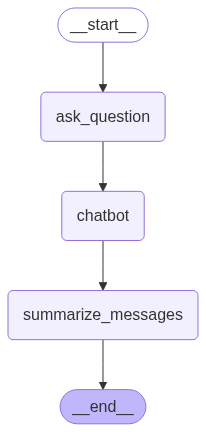

In [11]:
graph_compiled

In [12]:
config1 = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}

In [18]:
graph_compiled.invoke(State(), config1)


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

Piet Hein was born in Copenhagen, Denmark.

-------> ENTERING summarize_messages:

Update the ongoing summary by incorporating the new lines of conversation below. 
Build upon the previous summary rather than repeating it, 
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:


New Conversation:
ai: What is your question?

human: where was Piet Hein born?

ai: Piet Hein was born in Copenhagen, Denmark.





{'messages': [], 'summary': 'Piet Hein was born in Copenhagen, Denmark.'}

## State Snapshot

In [19]:
graph_states = [i for i in graph_compiled.get_state_history(config1)]

In [20]:
graph_states

[StateSnapshot(values={'messages': [], 'summary': 'Piet Hein was born in Copenhagen, Denmark.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05342d-4a58-610a-8003-78d640e57c06'}}, metadata={'source': 'loop', 'writes': {'summarize_messages': {'messages': [RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='cdf7b31b-7f33-475f-bdce-4b2950dfa024'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='8e8f1a46-ef9f-4f6f-a5ee-87ed5eaa0878'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='run--e43ef1d4-3ca1-4cec-aae4-391d36a5bdb7-0')], 'summary': 'Piet Hein was born in Copenhagen, Denmark.'}}, 'step': 3, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-27T10:38:14.904858+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05342d-3a6c-6331-8002-319e34407f29'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'messages': [AIM

In [21]:
for i in graph_states[::-1]:
    print(f'''
Messages: {i.values["messages"]}
Summary: {i.values.get("summary", "")}
Next: {i.next}
Step: {i.metadata["step"]}''')


Messages: []
Summary: 
Next: ('__start__',)
Step: -1

Messages: []
Summary: 
Next: ('ask_question',)
Step: 0

Messages: [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='cdf7b31b-7f33-475f-bdce-4b2950dfa024'), HumanMessage(content='where was Piet Hein born?', additional_kwargs={}, response_metadata={}, id='8e8f1a46-ef9f-4f6f-a5ee-87ed5eaa0878')]
Summary: 
Next: ('chatbot',)
Step: 1

Messages: [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='cdf7b31b-7f33-475f-bdce-4b2950dfa024'), HumanMessage(content='where was Piet Hein born?', additional_kwargs={}, response_metadata={}, id='8e8f1a46-ef9f-4f6f-a5ee-87ed5eaa0878'), AIMessage(content='Piet Hein was born in Copenhagen, Denmark.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 53, 'total_tokens': 63, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reas